<a href="https://colab.research.google.com/github/mohammedterry/ANNs/blob/master/Unsupervised_Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning

Download an Image (raw unlabelled data)

In [14]:
!curl -O https://media-assets-04.thedrum.com/cache/images/thedrum-prod/s3-news-tmp-1086-img_3175--2x1--940.png
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   213k      0 --:--:-- --:--:-- --:--:--  213k
'images?q=tbn:ANd9GcTEjN93orC8SXBxoNQnxaaOGiLuMmrGo8xPiYtlUelHirRr54LtxA'
 s3-news-tmp-1086-img_3175--2x1--940.png
 sample_data
 slack.jpg
'slack.jpg?w=100'


Resize it 

In [0]:
from PIL import Image
image = Image.open('s3-news-tmp-1086-img_3175--2x1--940.png')
image = image.resize((200, 100), Image.ANTIALIAS) 

Display it

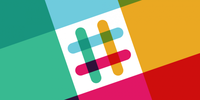

In [8]:
from IPython.display import display
display(image)

Convert it to a matrix of pixel values (an np array)

In [0]:
import numpy as np
image_array = np.asarray(image)

Normalise each pixel colour to be between 0 and 1

In [0]:
training_inputs,colours = [],[]
for row,pixels in enumerate(image_array):
  for column,abcd in enumerate(pixels):
    training_inputs.append((row,column))
    a,b,c,d = abcd
    colours.append((a/255,b/255,c/255,d/255))

due to small variations in shading, there are many different colours (even though there only look like 9). 

In [158]:
len(set(colours))

1597

We could train a classifier, we need to limit the number of classes it has to learn.  Is there some way to label these colours into just 9 colours?

## K Means Clustering


Lets use K-means clustering to automatically group the pixel colours into distinct classes (we will use these as labels).  This algorithm requires us to specify how many classes (k) we want to group the data into.  We can see there are about 5 unique colours so lets make 5 clusters (k = 5)

In [15]:
from sklearn.cluster import KMeans
kclusterer = KMeans(n_clusters = 5)
kclusterer.fit(colours)
kclusterer.labels_

array([3, 3, 3, ..., 1, 1, 1], dtype=int32)

lets confirm there are 5 distinct clusters in total

In [16]:
len(set(kclusterer.labels_))

5

lets visualise these clusters.  (First we need to reduce the colour vectors into 2D xy coordinates (for plotting) using Principal Components Analysis (PCA))

In [0]:
from sklearn.decomposition import PCA
reduced_dimensions = PCA(n_components=2)
coords = reduced_dimensions.fit_transform(colours)

Lets colour each cluster by the average of the colours that form it

In [18]:
import pandas as pd
cs = pd.DataFrame(data = colours, columns = ['r','g','b','a'])
cs['label'] = pd.Series(kclusterer.labels_)
colour_pallette = cs.groupby(['label']).mean().values

dataframe = pd.DataFrame(data = coords, columns = ['x', 'y'])
dataframe['colour'] = pd.Series(colours)
dataframe['label'] = pd.Series(kclusterer.labels_)
dataframe['label_colour'] = pd.Series([colour_pallette[cluster] for cluster in kclusterer.labels_])
dataframe.head()

,x,y,colour,label,label_colour
0,-0.226852,0.472040,"(0.09411764705882353, 0.5803921568627451, 0.49...",3,"[0.18511430458344785, 0.6757787333200092, 0.53..."
1,-0.224107,0.473111,"(0.09411764705882353, 0.5803921568627451, 0.49...",3,"[0.18511430458344785, 0.6757787333200092, 0.53..."
2,-0.226852,0.472040,"(0.09411764705882353, 0.5803921568627451, 0.49...",3,"[0.18511430458344785, 0.6757787333200092, 0.53..."
3,-0.226852,0.472040,"(0.09411764705882353, 0.5803921568627451, 0.49...",3,"[0.18511430458344785, 0.6757787333200092, 0.53..."
4,-0.226852,0.472040,"(0.09411764705882353, 0.5803921568627451, 0.49...",3,"[0.18511430458344785, 0.6757787333200092, 0.53..."


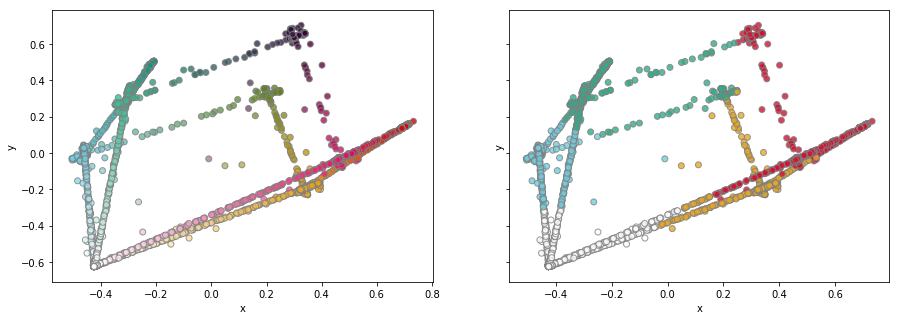

In [20]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))

import seaborn as sns
sns.regplot(ax=ax1, x="x", y="y",  fit_reg=False, scatter_kws={'facecolors':dataframe['colour'], 'color':'gray'}, data=dataframe)
sns.regplot(ax=ax2, x="x", y="y",  fit_reg=False, scatter_kws={'facecolors':dataframe['label_colour'], 'color':'gray'}, data=dataframe)

Lets show the image and replace the colours with the cluster colour (to see how similar it is to the original image)

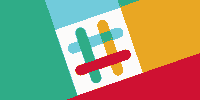

In [21]:
predicted_outputs = dataframe['label_colour'].values
predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    prediction = np.argmax(predicted_outputs[i])
    a,b,c,d = predicted_outputs[i] 
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)

It did a good job!  But lets imagine we didn't know how many clusters we want (image we couldnt easily inspect the data and decide before-hand that there should be k number of clusters).  What then?  (Try rerunning this algorithm with a different value for k!)

In [22]:
kclusterer = KMeans(n_clusters = 3)
kclusterer.fit(colours)
kclusterer.labels_

len(set(kclusterer.labels_))

3

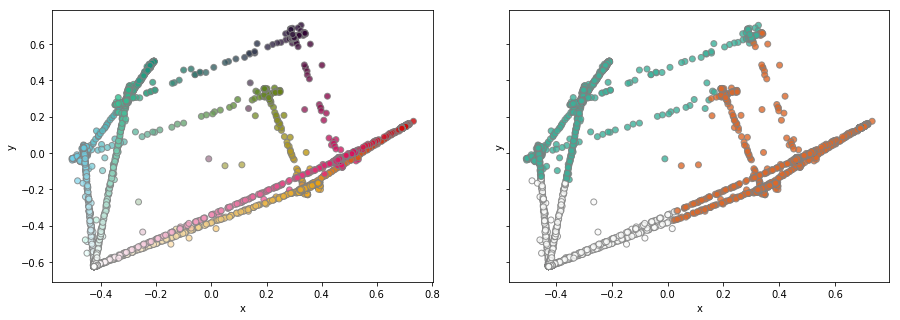

In [23]:
cs = pd.DataFrame(data = colours, columns = ['r','g','b','a'])
cs['label'] = pd.Series(kclusterer.labels_)
colour_pallette = cs.groupby(['label']).mean().values

dataframe = pd.DataFrame(data = coords, columns = ['x', 'y'])
dataframe['colour'] = pd.Series(colours)
dataframe['label'] = pd.Series(kclusterer.labels_)
dataframe['label_colour'] = pd.Series([colour_pallette[cluster] for cluster in kclusterer.labels_])

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
sns.regplot(ax=ax1, x="x", y="y",  fit_reg=False, scatter_kws={'facecolors':dataframe['colour'], 'color':'gray'}, data=dataframe)
sns.regplot(ax=ax2, x="x", y="y",  fit_reg=False, scatter_kws={'facecolors':dataframe['label_colour'], 'color':'gray'}, data=dataframe)

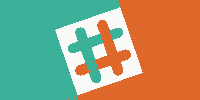

In [24]:
predicted_outputs = dataframe['label_colour'].values
predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    prediction = np.argmax(predicted_outputs[i])
    a,b,c,d = predicted_outputs[i] 
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)

Not so good now, right?  The number of clusters is quite important.  Is there a way to determine the best number of clusters automatically?

## Density Based Clustering
If we had no knowledge about the image, and didn't know how many colours we wanted it to be grouped into, we can use density based clustering which decides the number of clusters for us

In [25]:
from sklearn.cluster import DBSCAN
dclusterer = DBSCAN(eps=.05, min_samples=50)
dclusterer.fit(colours)
len(set(dclusterer.labels_))

9

The algorithm automatically discovered 9 clusters (although we still have two hyperparameters to tune carefully)

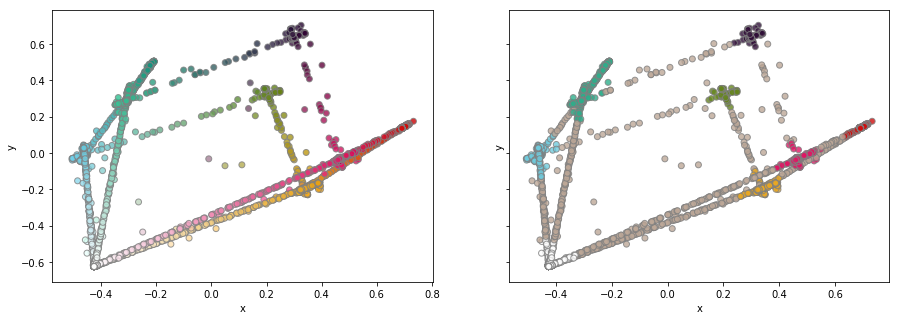

In [26]:
cs = pd.DataFrame(data = colours, columns = ['r','g','b','a'])
cs['label'] = pd.Series(dclusterer.labels_)
colour_pallette = cs.groupby(['label']).mean().values

dataframe = pd.DataFrame(data = coords, columns = ['x', 'y'])
dataframe['colour'] = pd.Series(colours)
dataframe['label'] = pd.Series(dclusterer.labels_)
dataframe['label_colour'] = pd.Series([colour_pallette[cluster + 1] for cluster in dclusterer.labels_])

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,5))
sns.regplot(ax=ax1, x="x", y="y",  fit_reg=False, scatter_kws={'facecolors':dataframe['colour'], 'color':'gray'}, data=dataframe)
sns.regplot(ax=ax2, x="x", y="y",  fit_reg=False, scatter_kws={'facecolors':dataframe['label_colour'], 'color':'gray'}, data=dataframe)

You can see that many of the outliers (grey) are not part of any cluster

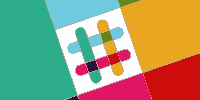

In [27]:
predicted_outputs = dataframe['label_colour'].values
predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    prediction = np.argmax(predicted_outputs[i])
    a,b,c,d = predicted_outputs[i] 
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)

it did a pretty good job on its own - notice the borders (those are the pixels without a class /cluster outliers). 

# Supervised Learning

Now that the image pixels are labelled with a cluster number, we can use the labelled data to train a classifier.  First lets convert the cluster numbers into onehot vectors so they can be understood by the classifier better

In [29]:
def onehot_vector(i):
  vec_len = len(set(dclusterer.labels_))
  vector = [0]*vec_len
  vector[i] = 1
  return vector

onehot_vector(3)

[0, 0, 0, 1, 0, 0, 0, 0, 0]

In [0]:
training_outputs = [onehot_vector(cluster+1) for cluster in dataframe['label'].values]

## Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(max_depth=10, n_estimators=100)
rf_classifier.fit(training_inputs, training_outputs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
rf_classifier.predict([[1,1]])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [0]:
predicted_outputs = rf_classifier.predict(training_inputs)

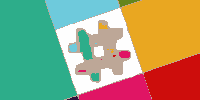

In [54]:
predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    p = predicted_outputs[i]
    p_cluster = list(p).index(max(p))
    p_colour = colour_pallette[p_cluster]
    a,b,c,d = p_colour
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)

Lets see how well the classifier has generalised.  Lets give it new data it has never seen before.  Lets ask it to predict what the image would look like beyond the borders

In [0]:
outoftraining_inputs = [(x-10,y+50) for x,y in training_inputs]

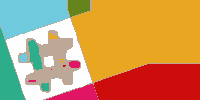

In [88]:
predicted_outputs = rf_classifier.predict(outoftraining_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    p = predicted_outputs[i]
    p_cluster = list(p).index(max(p))
    p_colour = colour_pallette[p_cluster]
    a,b,c,d = p_colour
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)

## Neural Network

In [92]:
from sklearn.neural_network import MLPClassifier
nn_classifier = MLPClassifier(hidden_layer_sizes = [100]*3)
nn_classifier.fit(training_inputs, training_outputs)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100, 100, 100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [57]:
nn_classifier.predict([[1,1]])

array([[0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [0]:
predicted_outputs = nn_classifier.predict(training_inputs)

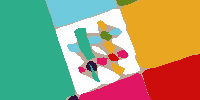

In [94]:
predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    p = predicted_outputs[i]
    p_cluster = list(p).index(max(p))
    p_colour = colour_pallette[p_cluster]
    a,b,c,d = p_colour
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)

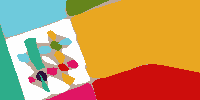

In [95]:
predicted_outputs = nn_classifier.predict(outoftraining_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,pixels in enumerate(predicted_image_array):
  for column in range(len(pixels)):
    p = predicted_outputs[i]
    p_cluster = list(p).index(max(p))
    p_colour = colour_pallette[p_cluster]
    a,b,c,d = p_colour
    predicted_image_array[row][column] = [a*255,b*255,c*255,d*255]
    i += 1
Image.fromarray(predicted_image_array)